# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


____

# 1. Global Config

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
DATA_SOURCE = 'balog'            # ['balog', 'gaussian', 'gamma', 'beta']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 5                        # Differential privacy level.
M = 1000                          # Number of data points.
N = 20                            # Number of support points.
DIM = 2                          # Dimension of data.
STEP_SIZE = 1e-3                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [3]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=1000 data points with dimension DIM=2


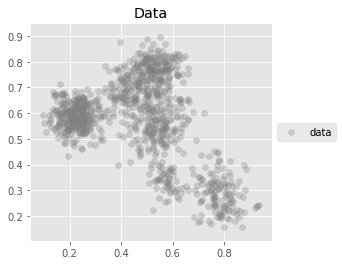

In [4]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    mus = data['MUS']
    weights = data['WEIGHTS']
    sigma_data = data['SIGMA_DATA']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:, 0], x[:, 1], c="gray", alpha=0.3,
                label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #            label='true centroids')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Data')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

___

# 3. Run Support Point Optimization

is_tf: True, y_init: radial, clip: bounds, weights: False

  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0399


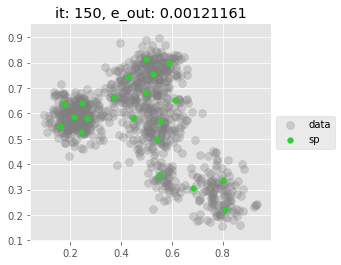

  [*] Overall it/s: 0.0360


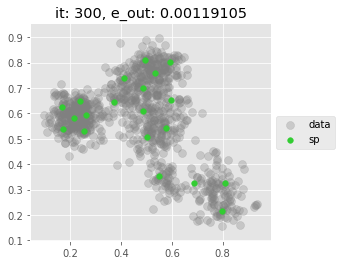

In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Define sensitivity.

In [6]:
# Define energy sensitivity for Exponential Mechanism.
# OLD: energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.3f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

Exp(2 * U / alpha) = Exp(2 * 0.2758 / 5.00) = Exp(0.110)


___

# 5. Sample support points.



--------- RUNNING DIFFUSION ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   548, e_opt:  0.001191, e~: 0.064898, energy(y,y~): 0.064914, error%: 0.000236


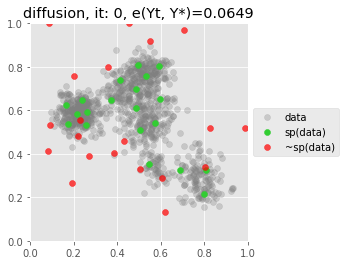

In [7]:
# Sampling parameters.
STEP_SIZE = 1e-2
NUM_Y_TILDES = 1

RUN_MH = 0
RUN_DIFFUSION = 1
PLOT = 1

if RUN_MH:
    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                       METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                       alpha=ALPHA)

if RUN_DIFFUSION:
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                              METHOD, STEP_SIZE, NUM_Y_TILDES,
                                              alpha=ALPHA)

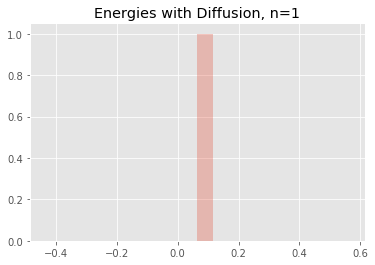

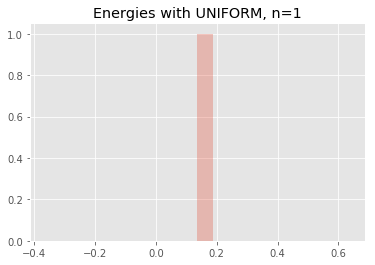

In [8]:
# Plot results of sampling for private support points.
if PLOT:
    if RUN_MH:
        plt.title('Energies with MH, n={}'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3)
        plt.show()

    if RUN_DIFFUSION:
        plt.title('Energies with Diffusion, n={}'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3)
        plt.show()

    # Compare to energies of e(y_opt, uniform)
    baseline_energies = np.zeros(NUM_Y_TILDES)
    for i in range(NUM_Y_TILDES):
        e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
        baseline_energies[i] = e_
    plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
    plt.hist(baseline_energies, bins=20, alpha=0.3)
    plt.show()

___

# 6. Expand to full data set.

### 6.0  Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   868, e_opt:  0.001191, e~: 0.085876, energy(y,y~): 0.086555, error%: 0.007900


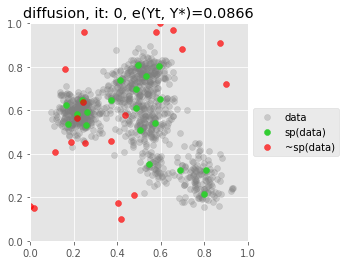

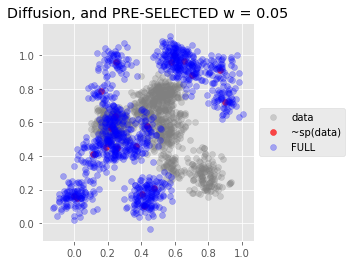

In [ ]:
# Show data and y_tilde.
NUM_Y_TILDES = 1
METHOD = 'diffusion'
BANDWIDTH = 0.05
FULL_SAMPLE_SIZE = M
STEP_SIZE = 1e-2

(y_tilde,
 y_tilde_upsampled,
 y_tilde_expansion,
 energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                  x, y_opt, STEP_SIZE, ALPHA,
                                                  BANDWIDTH, FULL_SAMPLE_SIZE, 
                                                  plot=True)

###  6.1  Show KDE over a range of bandwidths, and compute likelihood for each.

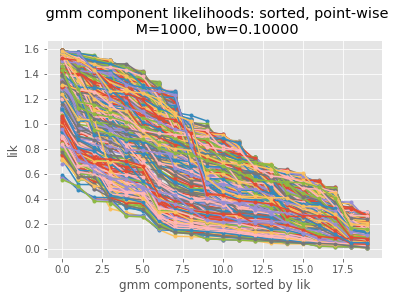

	 prod_liks=1.805e-177,
	 log_prod_liks=-4.070e+02,
	 sum_lliks=-4.070e+02




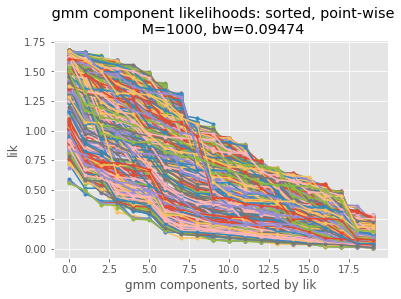

	 prod_liks=4.905e-170,
	 log_prod_liks=-3.898e+02,
	 sum_lliks=-3.898e+02




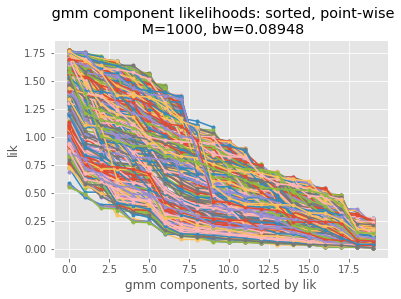

	 prod_liks=1.082e-162,
	 log_prod_liks=-3.729e+02,
	 sum_lliks=-3.729e+02




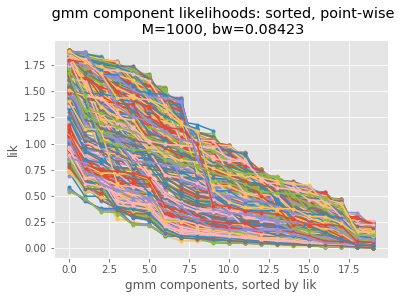

	 prod_liks=1.749e-155,
	 log_prod_liks=-3.563e+02,
	 sum_lliks=-3.563e+02




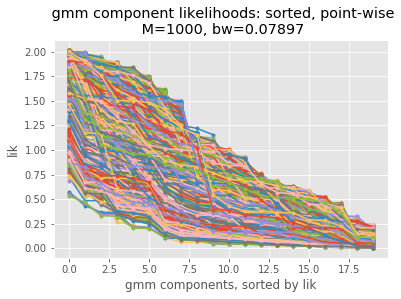

	 prod_liks=1.824e-148,
	 log_prod_liks=-3.402e+02,
	 sum_lliks=-3.402e+02




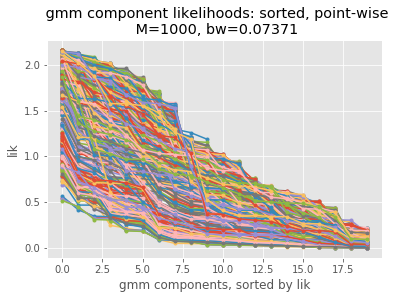

	 prod_liks=1.036e-141,
	 log_prod_liks=-3.246e+02,
	 sum_lliks=-3.246e+02




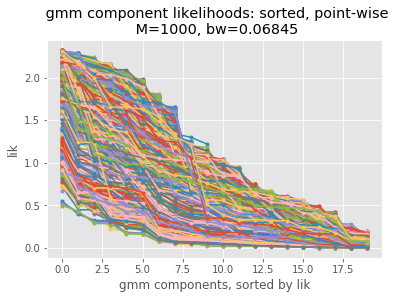

	 prod_liks=2.566e-135,
	 log_prod_liks=-3.099e+02,
	 sum_lliks=-3.099e+02




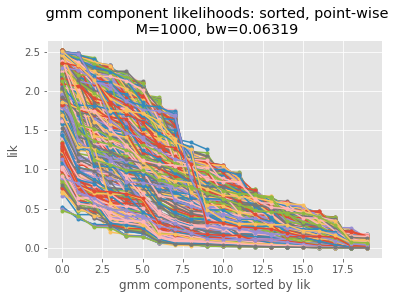

	 prod_liks=2.054e-129,
	 log_prod_liks=-2.963e+02,
	 sum_lliks=-2.963e+02




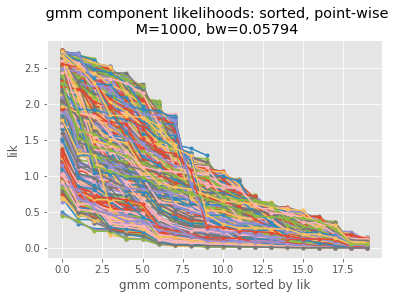

	 prod_liks=3.513e-124,
	 log_prod_liks=-2.843e+02,
	 sum_lliks=-2.843e+02




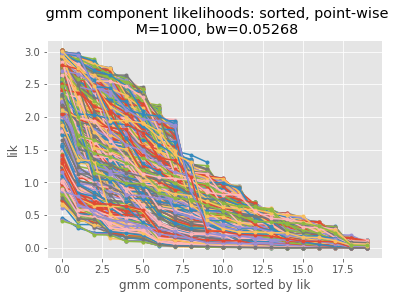

	 prod_liks=7.101e-120,
	 log_prod_liks=-2.743e+02,
	 sum_lliks=-2.743e+02




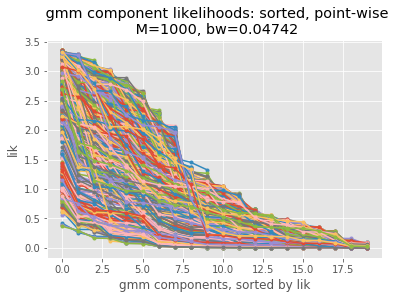

	 prod_liks=7.092e-117,
	 log_prod_liks=-2.674e+02,
	 sum_lliks=-2.674e+02




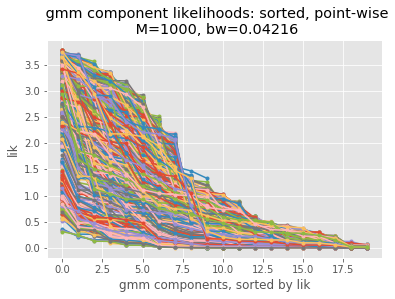

	 prod_liks=9.147e-116,
	 log_prod_liks=-2.649e+02,
	 sum_lliks=-2.649e+02




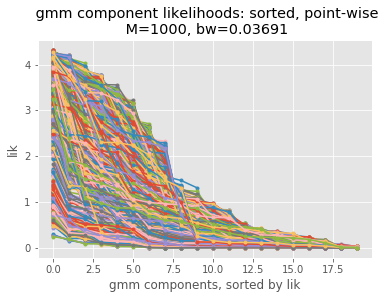

	 prod_liks=1.755e-117,
	 log_prod_liks=-2.688e+02,
	 sum_lliks=-2.688e+02




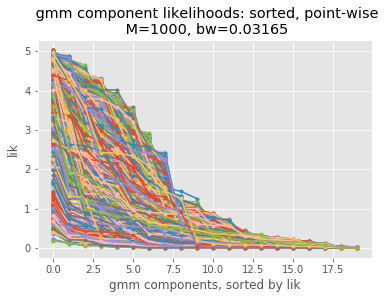

	 prod_liks=1.267e-123,
	 log_prod_liks=-2.830e+02,
	 sum_lliks=-2.830e+02




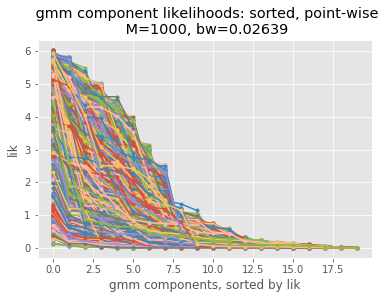

	 prod_liks=4.353e-137,
	 log_prod_liks=-3.140e+02,
	 sum_lliks=-3.140e+02




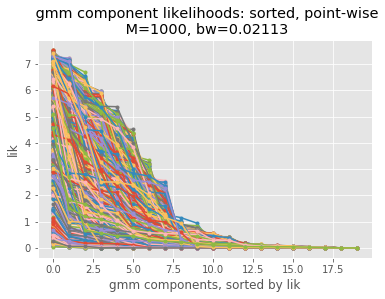

	 prod_liks=1.284e-163,
	 log_prod_liks=-3.751e+02,
	 sum_lliks=-3.751e+02




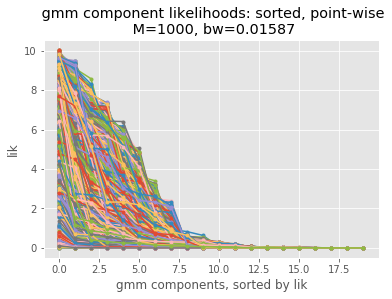

	 prod_liks=2.945e-216,
	 log_prod_liks=-4.963e+02,
	 sum_lliks=-4.963e+02




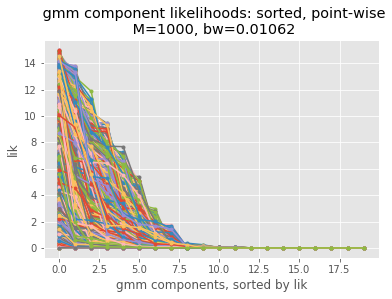

/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:731: RuntimeWarning: divide by zero encountered in log
  prod_liks, np.log(prod_liks), sum_lliks))
/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:732: RuntimeWarning: divide by zero encountered in log
  if prod_liks == 0. and np.log(prod_liks) == -np.Inf:


	 prod_liks=0.000e+00,
	 log_prod_liks=-inf,
	 sum_lliks=-7.659e+02




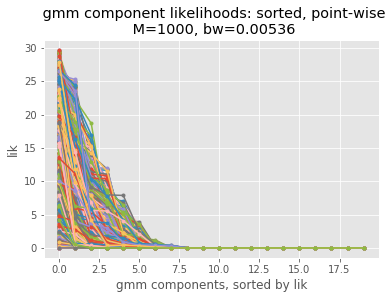

	 prod_liks=0.000e+00,
	 log_prod_liks=-inf,
	 sum_lliks=-1.649e+03




/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:684: RuntimeWarning: divide by zero encountered in log
  lliks.append(np.log(lik))


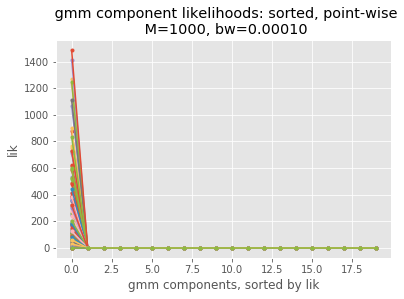

	 prod_liks=0.000e+00,
	 log_prod_liks=-inf,
	 sum_lliks=-inf




In [ ]:
# Find optimal bandwidth using Maximum Likelihood.
NUM_BANDWIDTHS = 20
BW_HIGH, BW_LOW = 0.1, 0.0001
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)
PLOT = 1

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE):    
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]

bw: 0.100000, lik: -4.07e+02
bw: 0.094742, lik: -3.90e+02
bw: 0.089484, lik: -3.73e+02
bw: 0.084226, lik: -3.56e+02
bw: 0.078968, lik: -3.40e+02
bw: 0.073711, lik: -3.25e+02
bw: 0.068453, lik: -3.10e+02
bw: 0.063195, lik: -2.96e+02
bw: 0.057937, lik: -2.84e+02
bw: 0.052679, lik: -2.74e+02
bw: 0.047421, lik: -2.67e+02
bw: 0.042163, lik: -2.65e+02
bw: 0.036905, lik: -2.69e+02
bw: 0.031647, lik: -2.83e+02
bw: 0.026389, lik: -3.14e+02
bw: 0.021132, lik: -3.75e+02
bw: 0.015874, lik: -4.96e+02
bw: 0.010616, lik: -7.66e+02
bw: 0.005358, lik: -1.65e+03
bw: 0.000100, lik: -inf


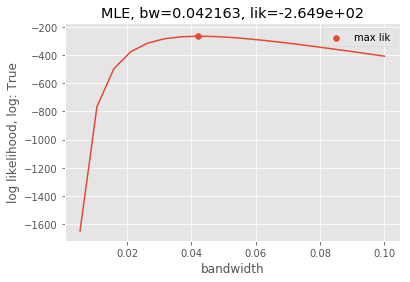

In [ ]:
# Plot results for various bandwidths.
for bw, lik in bw_lik:
    print('bw: {:.6f}, lik: {:.2e}'.format(bw, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel('log likelihood, log: {}'.format(do_log))
plt.title('MLE, bw={:.6f}, lik={:.3e}'.format(bw_best, bw_best_lik))
plt.legend()
plt.show()

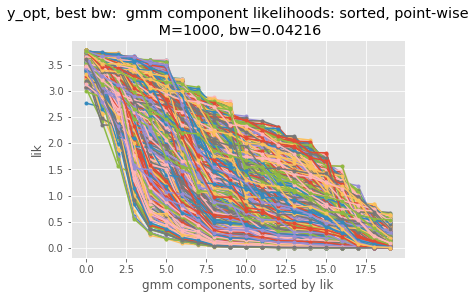

	 prod_liks=1.231e+192,
	 log_prod_liks=4.423e+02,
	 sum_lliks=4.423e+02




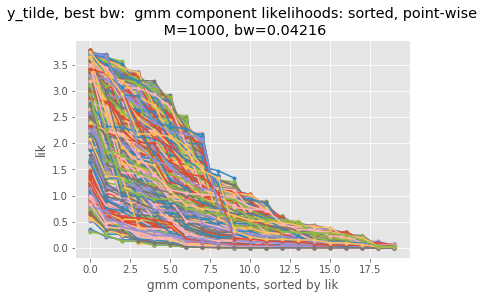

	 prod_liks=9.147e-116,
	 log_prod_liks=-2.649e+02,
	 sum_lliks=-2.649e+02


do_log: True
P(x | y_opt, bw_best): 4.42e+02
P(x | y_tilde, bw_best): -2.65e+02


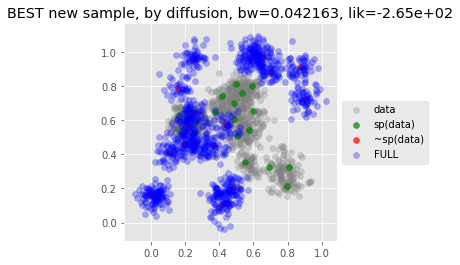

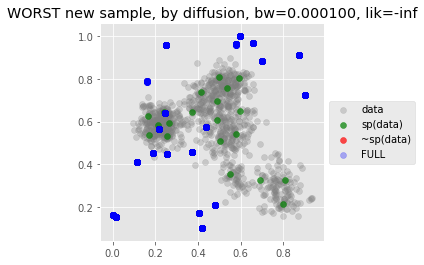

In [ ]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='y_opt, best bw: ')
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='y_tilde, best bw: ')

print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #    label='true centroids')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title('BEST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_best, bw_best_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #    label='true centroids')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title('WORST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_worst, bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

____

### 6.2. Try repeated draws of private support points, and concatenate results.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  4503, e_opt:  0.001191, e~: 0.155038, energy(y,y~): 0.155246, error%: 0.001346


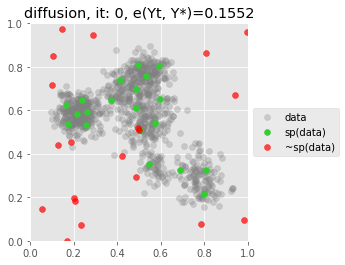


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count 13299, e_opt:  0.001191, e~: 0.170674, energy(y,y~): 0.170736, error%: 0.000367


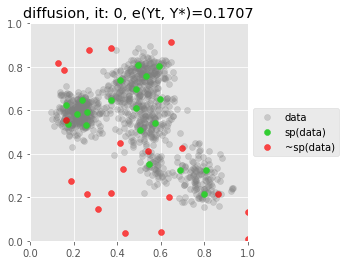


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count 21489, e_opt:  0.001191, e~: 0.306102, energy(y,y~): 0.308792, error%: 0.008789


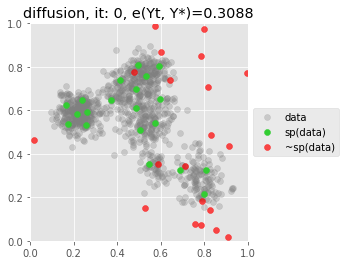


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  9105, e_opt:  0.001191, e~: 0.226103, energy(y,y~): 0.228826, error%: 0.012043


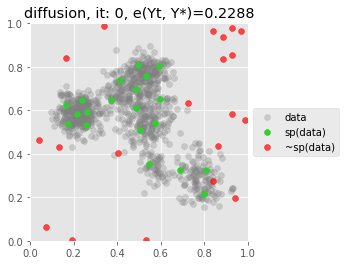


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  4650, e_opt:  0.001191, e~: 0.173412, energy(y,y~): 0.174056, error%: 0.003714


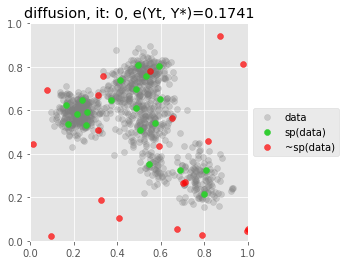


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   150, e_opt:  0.001191, e~: 0.032720, energy(y,y~): 0.033177, error%: 0.013974


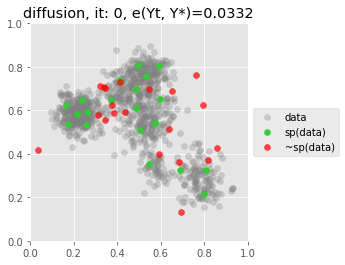


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count    53, e_opt:  0.001191, e~: 0.011316, energy(y,y~): 0.011371, error%: 0.004889


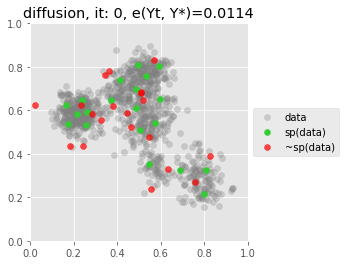


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   804, e_opt:  0.001191, e~: 0.084477, energy(y,y~): 0.085522, error%: 0.012371


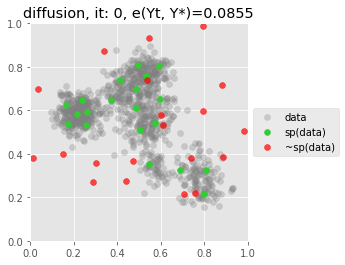


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  7170, e_opt:  0.001191, e~: 0.298240, energy(y,y~): 0.301668, error%: 0.011492


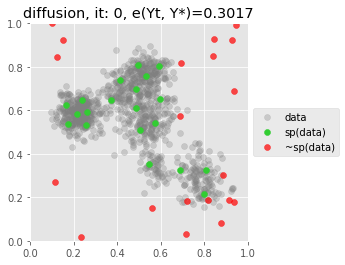


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  2200, e_opt:  0.001191, e~: 0.135656, energy(y,y~): 0.140762, error%: 0.037642


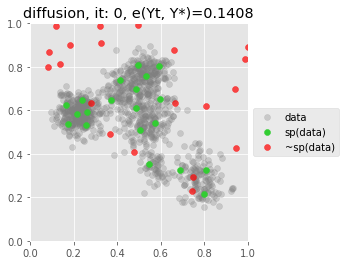


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   342, e_opt:  0.001191, e~: 0.035487, energy(y,y~): 0.036576, error%: 0.030689


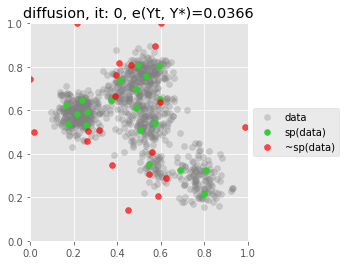


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  2291, e_opt:  0.001191, e~: 0.118376, energy(y,y~): 0.119061, error%: 0.005787


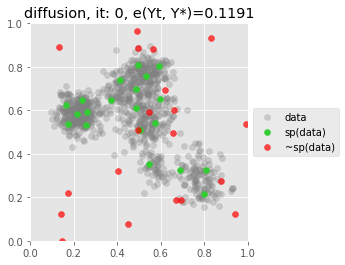


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count 10673, e_opt:  0.001191, e~: 0.258622, energy(y,y~): 0.260469, error%: 0.007145


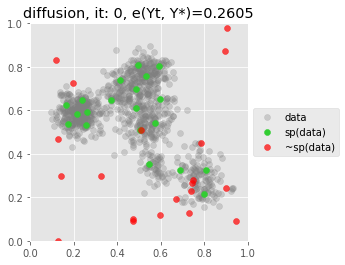


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   522, e_opt:  0.001191, e~: 0.054453, energy(y,y~): 0.054742, error%: 0.005313


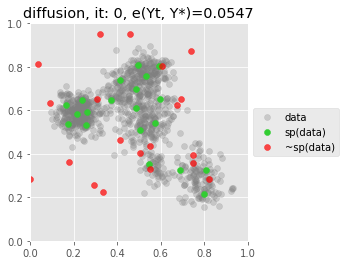


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   301, e_opt:  0.001191, e~: 0.044055, energy(y,y~): 0.044474, error%: 0.009496


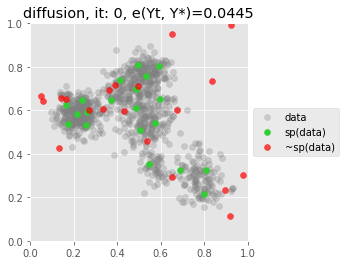


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  1669, e_opt:  0.001191, e~: 0.109616, energy(y,y~): 0.111517, error%: 0.017339


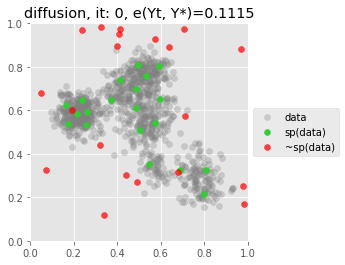


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  1873, e_opt:  0.001191, e~: 0.096828, energy(y,y~): 0.098735, error%: 0.019696


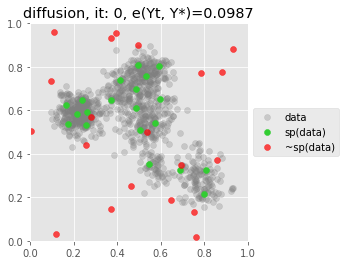


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count    28, e_opt:  0.001191, e~: 0.008739, energy(y,y~): 0.009466, error%: 0.083219


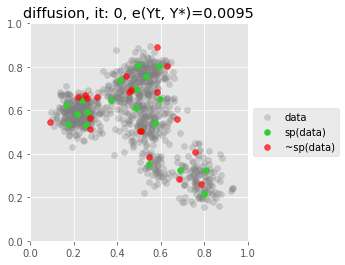


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   833, e_opt:  0.001191, e~: 0.080340, energy(y,y~): 0.080546, error%: 0.002560


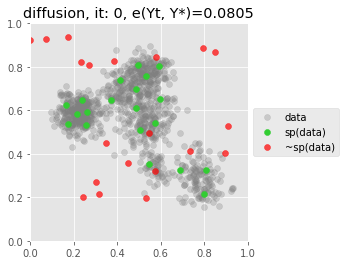


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   523, e_opt:  0.001191, e~: 0.074929, energy(y,y~): 0.075917, error%: 0.013179


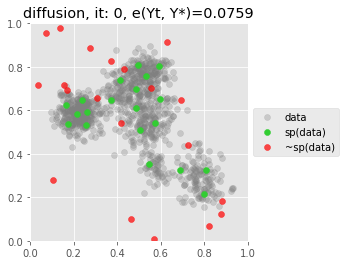


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count 138089, e_opt:  0.001191, e~: 0.299436, energy(y,y~): 0.303454, error%: 0.013422


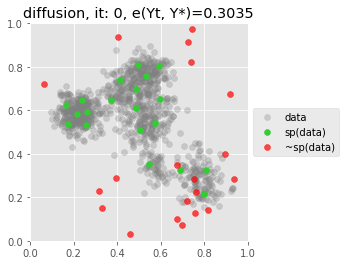


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count     7, e_opt:  0.001191, e~: 0.004011, energy(y,y~): 0.004446, error%: 0.108549


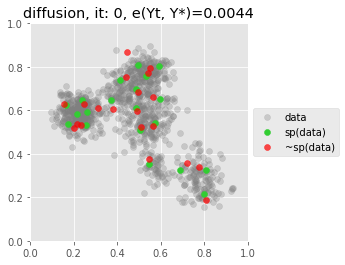


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   390, e_opt:  0.001191, e~: 0.069366, energy(y,y~): 0.072378, error%: 0.043423


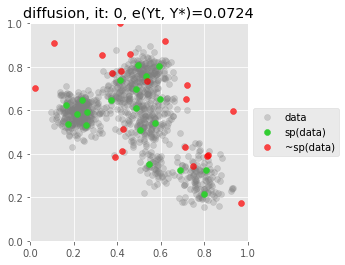


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  1381, e_opt:  0.001191, e~: 0.116483, energy(y,y~): 0.121405, error%: 0.042258


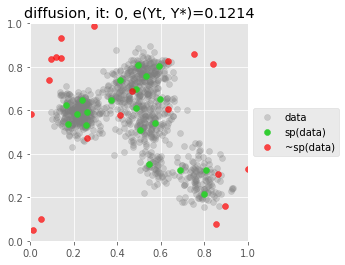


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   775, e_opt:  0.001191, e~: 0.069839, energy(y,y~): 0.070578, error%: 0.010583


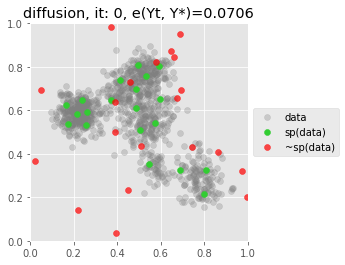


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   193, e_opt:  0.001191, e~: 0.040032, energy(y,y~): 0.040359, error%: 0.008168


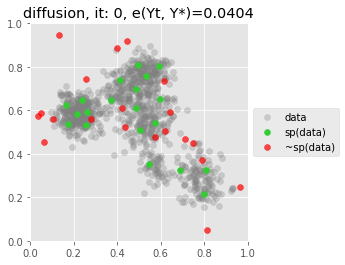


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count    16, e_opt:  0.001191, e~: 0.005185, energy(y,y~): 0.005729, error%: 0.104986


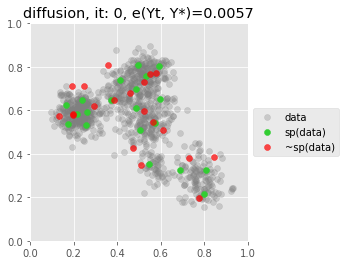


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  1568, e_opt:  0.001191, e~: 0.133519, energy(y,y~): 0.133612, error%: 0.000696


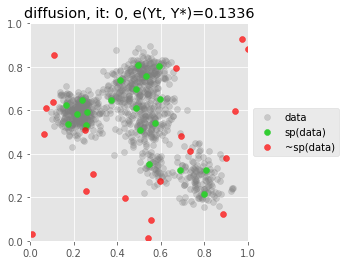


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   354, e_opt:  0.001191, e~: 0.047422, energy(y,y~): 0.047780, error%: 0.007541


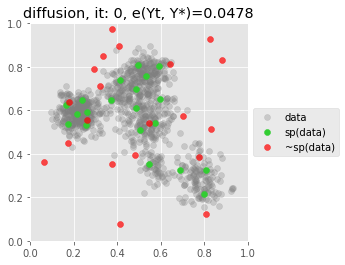


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   261, e_opt:  0.001191, e~: 0.035951, energy(y,y~): 0.036068, error%: 0.003263


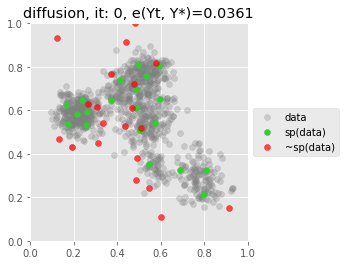


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count    71, e_opt:  0.001191, e~: 0.016497, energy(y,y~): 0.016525, error%: 0.001724


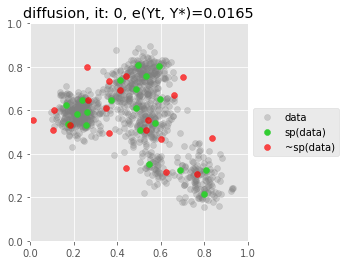


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  3009, e_opt:  0.001191, e~: 0.169528, energy(y,y~): 0.171623, error%: 0.012356


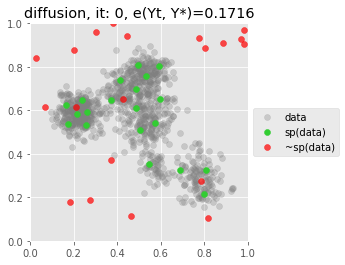


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count     1, e_opt:  0.001191, e~: 0.001257, energy(y,y~): 0.001694, error%: 0.347948


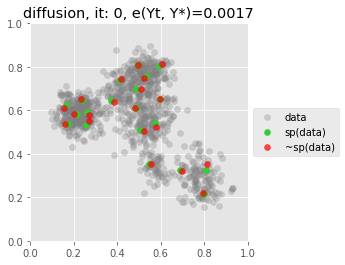


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  1242, e_opt:  0.001191, e~: 0.116057, energy(y,y~): 0.117151, error%: 0.009423


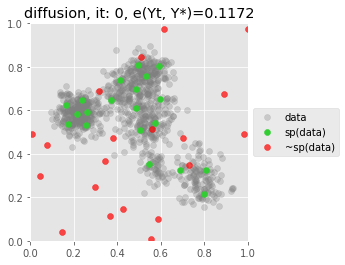


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  1428, e_opt:  0.001191, e~: 0.092591, energy(y,y~): 0.093045, error%: 0.004909


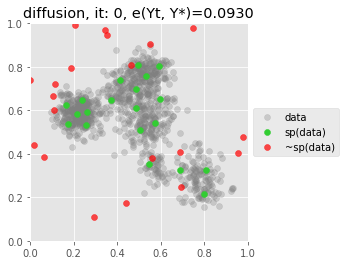


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   841, e_opt:  0.001191, e~: 0.066169, energy(y,y~): 0.068002, error%: 0.027702


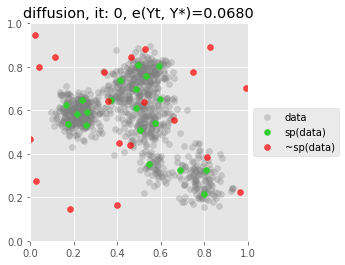


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count   389, e_opt:  0.001191, e~: 0.079942, energy(y,y~): 0.081612, error%: 0.020892


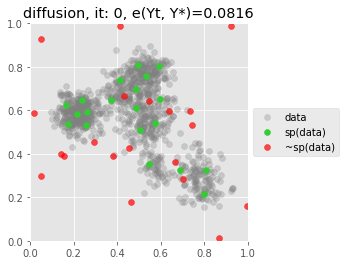


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  1147, e_opt:  0.001191, e~: 0.124391, energy(y,y~): 0.125332, error%: 0.007563


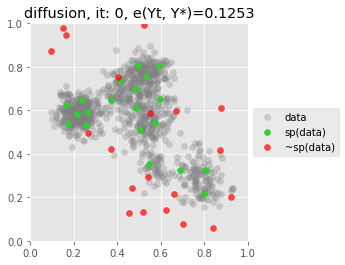


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count 14638, e_opt:  0.001191, e~: 0.233172, energy(y,y~): 0.233966, error%: 0.003403


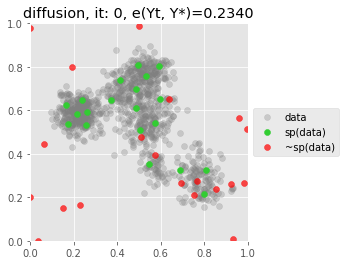


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count    24, e_opt:  0.001191, e~: 0.007834, energy(y,y~): 0.008154, error%: 0.040933


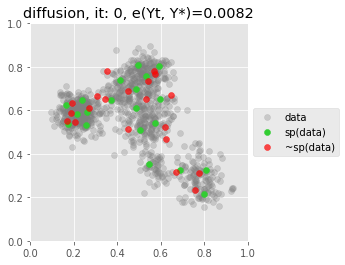


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)

Diffusion count  2641, e_opt:  0.001191, e~: 0.127753, energy(y,y~): 0.128097, error%: 0.002697


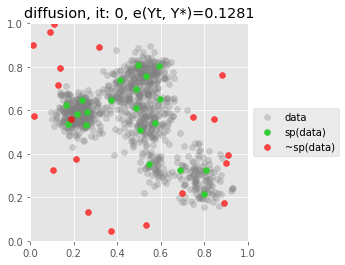


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 5.000) = Exp(0.1103)



In [ ]:
NUM_REPEATS = int(M / N) + 1
new_sample = []
STEP_SIZE = 1e-2

#print('NOTE: CHANGED ALPHA!')
#ALPHA = NUM_REPEATS * ALPHA

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE,
                                                      ALPHA, BANDWIDTH,
                                                      FULL_SAMPLE_SIZE)
    new_sample.append(y_tilde)

print('\nConcatenating results, and plotting collection of samples as one.\n')

new_sample = np.concatenate(new_sample)

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
# plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')

plt.title('{}, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    METHOD, ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 6.3 Use DP sample of median of pairwise distances as bandwidth.
Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W.

In [ ]:
if 0:
    # Show data and y_tilde.
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    # Compute median of pairwise distanes, and use that as bandwidth.
    median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
    sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
    private_median = median_pairwise_dists + np.random.laplace(
        scale=sensitivity_median_pairwise_dists / ALPHA)
    print(median_pairwise_dists)
    print(private_median)
    #pdb.set_trace()

    """
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      private_median, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    """

# End.